# Neural Net for Semantic Image Segmentation
#### Kaggle Competition (https://www.kaggle.com/c/cvpr-2018-autonomous-driving)
#### Stanford course CS231n
#### Aristos Athens (aristos@stanford.edu)
#### Alice Li (ali2@stanford.edu)
#### Amelia Bian (qb1@stanford.edu)

In [1]:
from util import *

import os
import tensorflow as tf
import numpy as np
import glob
import math
import random
import timeit
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from scipy import stats
import gc
import psutil
import shutil
from PIL import Image

import keras
from keras import backend as K
from tensorflow.python.keras.applications import vgg16, inception_v3, resnet50, mobilenet
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

%matplotlib inline
CUDA_VISIBLE_DEVICES=0

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## HyperParameters

In [2]:
class HyperParameters:
    """
    Object to hold all hyperparameters. Makes passing parameters between functions easier.
    Many of these might not be strictly necessary.
    
    """
    def __init__(self):
        # General params
        self.data_type = tf.float32
        self.root = '../data/cvpr-2018-autonomous-driving/train_color'
        self.device = '/cpu:0'
        
        # Training params
        self.optimizer = "Adam"    # options: SGD, RMSProp, Momentum, Adam, Adagrad
        self.learning_rate = 1e-4
        self.lr_decay = 0.99
        self.loss_type = "full"    # options: "fast", "full"
        self.momentum = 0.9
        self.use_Nesterov = True
        self.init_scale = 7.0
        self.num_epochs = 30       # Total data to train on = num_epochs*batch_size
        
        self.print_images = False
        self.verbose = True
        
        # Data loader params
        self.shuffle_data = True   # Currently doesn't do anything
        self.num_classes = 20      # This value is probably wrong
        self.preload = False
        self.batch_size = 12
        self.num_files_to_load = self.num_epochs * self.batch_size
        
        # Saved model params
        self.save_model = True
        self.use_saved_model = False
        
              
hp = HyperParameters()

## Here we create a customized data loader for the CVPR dataset

In [3]:
class CVPR(object):
    """
    A customized data loader for CVPR.
    """
    def __init__(self, root, transform=None, batch_size = 10):
        """ Intialize the CVPR dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        # Important - This tracks which batch we are on. Used for loading as we go (as opposed to preloading)
        self.batch_num = 0
        
        # read filenames
        self.filenames = []
        filenames = glob.glob(osp.join(hp.root, '*.jpg'))
        np.random.shuffle(filenames)
        for fn in filenames:
            lbl = fn[:-4] + '_instanceIds.png'
            lbl = lbl.replace('color', 'label')
            self.filenames.append((fn, lbl)) # (filename, label) pair
            if len(self.filenames) >= hp.num_files_to_load: 
                break
                
        self.labels = []
        self.images = []
        if hp.preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        for image_fn, label in self.filenames:
            # load images
            image = Image.open(image_fn)
            self.images.append(np.asarray(image))            # avoid too many opened files bug
            image.close()
            # load labels
            image = Image.open(label)
            self.labels.append((np.asarray(image)/1000).astype(int))             # avoid too many opened files bug
            image.close()
    
        assert len(self.images) == len(self.labels), 'Got different numbers of data and labels'
#         assert self.images[0].shape == self.labels[0].shape, 'Got data and labels with different shapes'

        
    def __getitem__(self, index):
        """
        Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            label = Image.open(label)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            label = self.transform(label)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
    
    def __iter__(self):
        N, B = hp.num_files_to_load, hp.batch_size
        return iter((self.images[i:i+B], self.labels[i:i+B]) for i in range(0, N, B))
    
    def update_iterator(self):
        # If a batch has already been loaded free the last batch
        if len(self.images) != 0:
            for image in self.images:
                del image
            for label in self.labels:
                del label
        del self.images
        del self.labels
        self.images = []
        self.labels =[]
        gc.collect()
        i = self.batch_num*hp.batch_size
        train_filenames = self.filenames[i:i + hp.batch_size]
        for image_fn, label in train_filenames:
            image = Image.open(image_fn)
            self.images.append(self.normalize_image(np.asarray(image)))
            image.close()
            del image
            image = Image.open(label)
            self.labels.append((np.asarray(image)/1000).astype(int))
            image.close()
            del image
        gc.collect()
        self.batch_num += 1
        
    def get_images(self):
        return self.images, self.labels

    def normalize_image(self, image):
        # Normalize the data: subtract the mean pixel and divide by std
        mean_pixel = image.mean(keepdims=True)
        std_pixel = image.std(keepdims=True)
        image = (image - mean_pixel) / std_pixel
        return image
    
    def reset_data_set(self):
        self.batch_num = 0
        np.random.shuffle(self.bfilenames)
        del self.images
        del self.labels
        gc.collect()
        self.images = []
        self.labels = []
        

## Define Net

In [ ]:
def create_model(inputs, is_training):
    
    initializer = tf.variance_scaling_initializer(scale=hp.init_scale)
#     initializer = tf.contrib.layers.xavier_initializer()
    input_shape = (2710, 3384, 3)
    
    # Transfer learning example here:
    # https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
#     base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Not 100% sure what this line does
#     model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#     from pympler import asizeof
#     print(asizeof.asizeof(base))
    
    model = tf.keras.Sequential()
#     for layer in base.layers:
#         layer.trainable = False
#     model.add(base)
    
    # Add our own layers to the layers list within the model
    regularizer = tf.contrib.layers.l2_regularizer(0.01)
    layers = [
        # Downsampling layers
        tf.keras.layers.Conv2D(5, (3, 3), kernel_initializer = initializer, input_shape=input_shape, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),

        tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides = (4, 4), padding = "valid"),
        
        tf.keras.layers.Conv2D(12, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(16, (5, 5), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = "valid"),
        
        tf.keras.layers.Conv2D(24, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = "valid"),
        
        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),

        # Upsampling layers
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        
        tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        tf.keras.layers.ZeroPadding2D(padding=((0,1),(1,1))),
        
        tf.keras.layers.Conv2D(24, (5, 5), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(16, (5, 5), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        
        tf.keras.layers.UpSampling2D(size=(4, 4)),
        tf.keras.layers.ZeroPadding2D(padding=((1,1),(0,0))),
        
        tf.keras.layers.Conv2D(12, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(10, (3, 3), kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(1, (3, 3), activation=None, kernel_initializer = initializer, padding = "SAME", kernel_regularizer=regularizer),
        tf.keras.layers.LeakyReLU(alpha=0.0)
        
    ]
#     model.add(layers)
    for layer in layers:
        model.add(layer)

    return model(inputs)

def create_optimizer(hp):
    
    optimizer = None
    if hp.optimizer == "Momentum":    
        optimizer = tf.train.MomentumOptimizer(learning_rate=hp.learning_rate, momentum=hp.momentum, use_nesterov=hp.use_Nesterov)
    if hp.optimizer == "Adam":    
        optimizer = tf.train.AdamOptimizer(learning_rate=hp.learning_rate, beta1=hp.lr_decay)
    if hp.optimizer == "AdaGrad":
        optimizer = tf.train.AdagradOptimizer(learning_rate=hp.learning_rate)
    if hp.optimizer == "SGD":
        optimizer = tf.train.SGDOptimizer(learning_rate=hp.learning_rate, lr_decay=hp.lr_decay)
    if hp.optimizer == "RMSProp":
        optimizer = tf.train.RMSPropOptimizer(learning_rate=hp.learning_rate, decay=hp.lr_decay, momentum=hp.momentum, epsilon=1e-10)
    
    return optimizer

## Train net

Instructions for updating:
Use the retry module or similar alternatives.

Starting training loop...

Starting batch 0...

WEIGHTED IMAGES min: 0 | max: 1282 | mean: 10
INT IMAGES min: 0 | max: 1282 | mean: 10
WEIGHTED LABELS min: 0 | max: 65 | mean: 0
LABELS min: 0 | max: 65 | mean: 0
best pair:  1
means list [0.0005791302516584185, 0.000818118741132732]


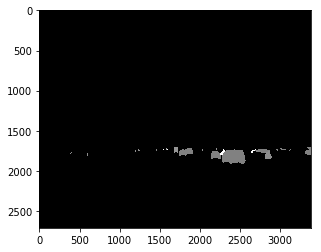

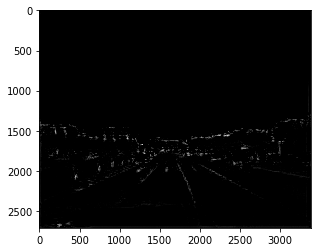

Batch 0  |  Loss = 8.7755  |  Positive Accuracy = 0.0007  |  Total Accuracy = 0.9092

Number of Graph Ops Stored:  1491
Starting batch 1...

WEIGHTED IMAGES min: 0 | max: 1477 | mean: 8
INT IMAGES min: 0 | max: 1477 | mean: 8
WEIGHTED LABELS min: 0 | max: 65 | mean: 2
LABELS min: 0 | max: 65 | mean: 2
best pair:  0
means list [0.0008828549028653653, 0.00048183824703696776]


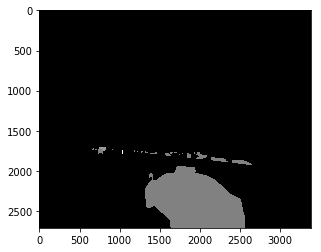

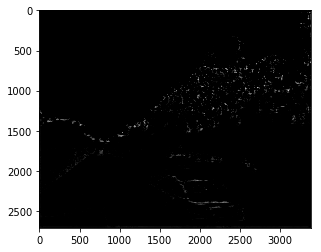

Batch 1  |  Loss = 37.6611  |  Positive Accuracy = 0.0007  |  Total Accuracy = 0.8672

Number of Graph Ops Stored:  1511
Starting batch 2...



In [ ]:
def train_net(hp, data_set, create_model, create_optimizer):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - create_model: A function that takes no parameters; when called it
      constructs the model we want to train: model = create_model()
    - create_optimizer: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = create_optimizer()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during training
    """
    tf.reset_default_graph()
        
    with tf.device(hp.device):
        # Construct the computational graph we will use to train the model. We
        # use the create_model to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(hp.data_type, [None, 2710, 3384, 3])
#         y = tf.placeholder(np.dtype('int32'), [None, 2710, 3384])
        y = tf.placeholder(hp.data_type, [None, 2710, 3384])

        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')

        # Use the model function to build the forward pass.
        output = tf.squeeze(create_model(x, is_training))

        # Full loss type is better
        if hp.loss_type == "full":
#             loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y, dim=0))
            loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=output, targets=y, pos_weight=40))
#             loss = 1/tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.squeeze(output), tf.int32), tf.squeeze(y)), tf.int32))
        if hp.loss_type == "fast":
            loss = tf.reduce_mean(tf.square(y - output))
#             loss = tf.reduce_mean(y - output)

        # Use the create_optimizer to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.

        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.

        optimizer = create_optimizer(hp)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer_step = optimizer.minimize(loss)

                
                
    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the model to update.
    # # Total data to train on = num_epochs*batch_size
    
#     data_iterator = data_set.__iter__()
    train_images = []
    train_labels = []
    train_output = None    
    
    with tf.Session() as sess:
        if hp.use_saved_model:
            load_saved_model(sess)   
        if hp.save_model:
             builder = create_saver(sess) 
                  
        sess.run(tf.global_variables_initializer())
        print("\nStarting training loop...\n")
        
        for epoch in range(hp.num_epochs):
            print('Starting batch %d...\n' % epoch)
            data_set.update_iterator()
            train_images, train_labels = data_set.get_images()
            feed_dict = {x: train_images, y: train_labels, is_training: 1}
            loss_value, _, train_output = sess.run([loss, optimizer_step, output], feed_dict=feed_dict)
            accuracy, total_acc = check_accuracy(hp, sess, train_output, train_labels)
            print('Batch %d  |  Loss = %.4f  |  Positive Accuracy = %.4f  |  Total Accuracy = %.4f\n' % (epoch, loss_value, accuracy, total_acc))
            gc.collect()
            print_graph_size()
                
        data_set.reset_data_set()
        save_model(sess, builder)
    

data_set = CVPR(hp.root, transform = tf.convert_to_tensor)              
train_net(hp, data_set, create_model, create_optimizer)